# Dimensionality Reduction 

In this tutorial, we will explore dimensionality reduction using a very common approach, Principal Component Analysis (PCA), and how it can be applied to spatio-temporal data to discover patterns in climate data.

## Principal Component Analysis

PCA is a linear dimensionality reduction technique. It is used to linearly transform data to a new coordinate system, based on the principal components of the data. The principal components capture the directions of greatest variance in the data, in decreasing order. That is, the first principal component will explain the greatest variance in the data, and the second principal component will explain the next greatest variance after the first principal component has been removed. To illustrate this, we will generate some fake data; this follows the implementation in the [Dimensionality Reduction notebook](https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynb) from *Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow* by Aurélien Géron.

This code creates a 3D data set, which consists of an oval shape in 3D with points distributed unevenly and with a lot of noise:

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

In [2]:
X.shape

(60, 3)

If we take the first 2 principal components of this data set, we are effectively learning a projection from 3D down to 2D. This figures shows a plot of the original 3D dataset, projected onto a 2D plane using PCA. 

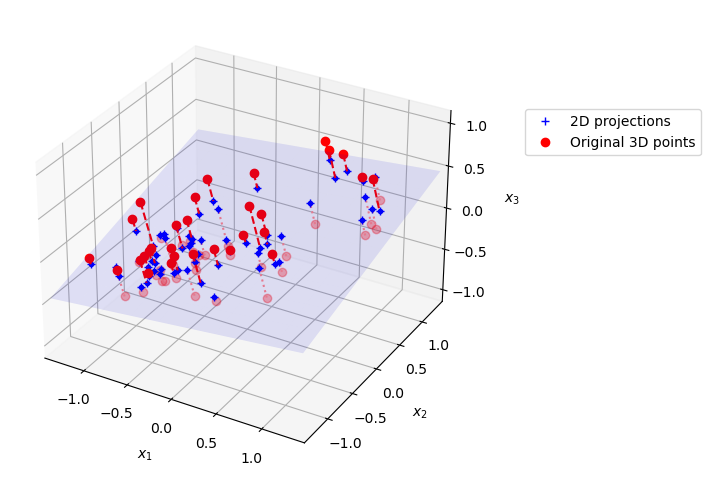

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)

U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+",label="2D projections")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro",label="Original 3D points")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])
plt.legend(bbox_to_anchor=(1.1, 0.8), loc='upper left')

plt.show()

Our data is in a data matrix $\mathbf{X}$, which has the dimensions $n_{samples}$ by $n_{features}$.

To perform PCA analysis, you would follow these steps:
1) Mean-center the data: First, subtract the mean of each feature from the data set. This centers the data around the origin.
$$
\mathbf{X}_{c} = \mathbf{X} - \mathbf{X}_{mean}
$$
2) Next, apply Singular Value Decomposition (SVD) to the centered data matrix, which is a matrix factorization approach:
$$
\mathbf{X}_{c} = \mathbf{U}\Sigma\mathbf{V^{T}}
$$

The columns of $\mathbf{V}$ (the rows of $\mathbf{V^{T}}$) are the principal directions (eigenvectors of the covariance matrix).
The singular values in $\Sigma$ relate to the explained variance of each principal component. 

We can implement PCA directly by using the SVD factorization algorithm implemented in the `numpy` library. 

In [4]:
import numpy as np

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

The principal directions for our data are then:

In [5]:
print(c1)
print(c2)

[0.67857588 0.70073508 0.22023881]
[-0.72817329  0.6811147   0.07646185]


We can also use `sci-kit learn` to do this instead, where it is very easy to implement PCA. In this case, it is not necessary to subtract the mean, since this is done automatically.

In [28]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

The principal directions in the data can be found by printing the `pca.components_`

In [8]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

The explained variance ratio tells us how much variance in our original 3D data each component explains.

In [9]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

This means that the first dimension explains about 76% of the variance, while the second explains 15%

In [10]:
1 - pca.explained_variance_ratio_.sum() 

0.09028309326742046

By projecting from 3D to 2D we have lost ~9% of the variance in our original data set.

This next code uses the dataset MNIST to explore how we can figure out how many dimensions we should keep in our data set. MNIST is a data set of small images of (labeled) handwritten digits (0,1,2,3,4,5,6,7,8,9), and is used to benchmark many machine learning models.

In [11]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

In [12]:
X_train.shape

(60000, 784)

The data set contains 28x28 pixel images, but here the images are flattened into a single vector of 28*28 = 784 points. To visualize an example, we can reshape the data to 28x28 pixels and plot the image.

In [13]:
imgexample = X_train[20,:].reshape(28,28)

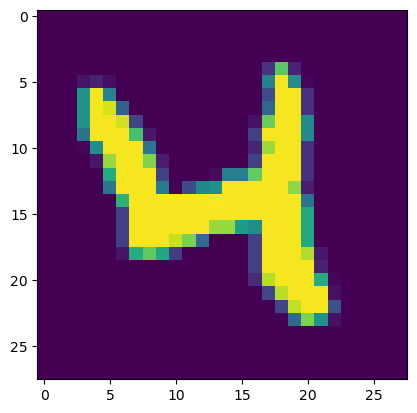

In [14]:
plt.imshow(imgexample)

For the sake of this example, we are using MNIST as a high dimensional data set that we might want to apply dimensionality reduction to. We'll start by applying PCA to the training data set.

In [15]:
pca = PCA()
pca.fit(X_train)

PCA()

If we don't specify how many components to keep, PCA will return a number that is the same size as our original number of features:

In [16]:
pca.n_components_

784

We can determine how many principal components that we need in order to retain 95% of the original variance in the MNIST dataset:

In [17]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  

This indicates that we need to keep 154 principal components.

In [18]:
d

154

If we use the following lines of code, we can tell PCA to automatically choose the number of components such that at least 95% of the variance in the original data set is retained. We can then transform the data to this new, lower dimensional space.

In [19]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [20]:
pca.n_components_

154

In [21]:
pca.explained_variance_ratio_.sum()  # extra code

0.950196019261303

We can look at the cumulative sum of the explained variance as we increase the number of components that we keep:

In [22]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)

plt.show()

PCA can be used to compress data, because we can keep the majority of information in our original data set but with many fewer variables. If we look at X_reduced, it contains 154 features (while our original $\mathbf{X}$ contains 784 features)

In [23]:
X_reduced.shape

(60000, 154)

We can use the inverse transform to reconstruct the original data set from our reduced feature matrix:

In [24]:
X_recovered = pca.inverse_transform(X_reduced)

In [25]:
X_recovered.shape

(60000, 784)

The lines below show examples of the original images, and the ones that have been reconstructed from the 154 features.

In [26]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

This type of compression is one way that we can do feature engineering for machine learning; if we have an original high dimensional data set, we might first apply PCA (or some other dimensionality reduction method) to our data, and then use the first few principal components as input to our machine learning algorithm. This approach is useful because it ensures that we both focus on the most significant sources of variance describing the high dimensional data set, while also reducing the total number of features.

## Using PCA to discover the El Niño/Southern Oscillation (ENSO) pattern

As an example of how PCA can be applied to climate data, we will look at an analysis of the tropical Pacific sea surface (SST) to reveal the signature of the El Niño/Southern Oscillation (ENSO) phenomenon. This follows the analysis described [here](https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/chapters/Week7/Intro_to_PCA.html). ENSO is an important pattern of climate variability on the seasonal to multi-year timescale. It is related to warmer/colder sea surface temperatures in the central and eastern Pacific Ocean, which also leads to changes in the trade winds. 

When PCA is applied to spatial-temporal data (like we will do here) is often referred to as Empirical Orthogonal Function (EOF) analysis. The two methods are effectively equivalent (PCA is the terminology used in statistics and machine learning, while EOF analysis is the conventional terminology that is used in climate science and meteorology). The spatial patterns that are discovered by PCA analysis are referred to as EOFs (Empirical Orthogonal Functions), and these represent the dominant modes of spatial variability that are found in the data set. The corresponding time series that describe how the amplitude of these spatial patterns change over time are called principal components (PCs) or scores.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

We will use a data set from NOAA of monthly SSTs from 1854 until 2025, which can be accessed by running this code:

In [2]:
sst = xr.open_dataset("http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc")

In [3]:
sst

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2058, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2025-06-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2025-07-03
    DODS_EXTRA.Unlimited_Dimension:  time

We'll plot an example of the SST data for one of the months:

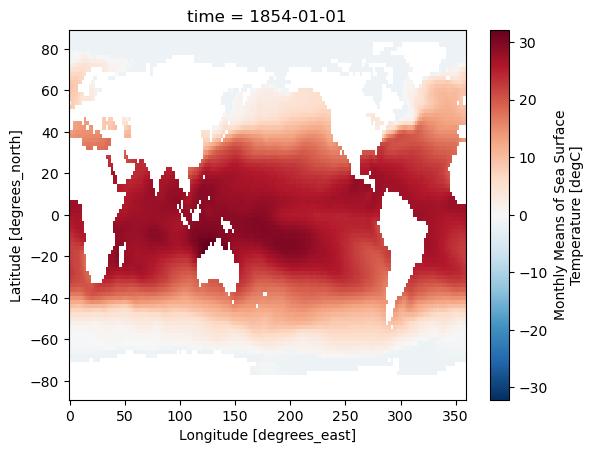

In [4]:
sst['sst'][0].plot()

We'll first calculate the **Niño3.4 index**, which is a commonly used metric of ENSO variability. To do this we will
1. Compute the area-averaged total SST from (5N-5S,190E-240E)
2. Compute the montly climatology from 1950 - 1979 for the area-averaged total SST for this region, and subtract the climatology from the area averaged total SST time series to obtain anomalies.
3. Smooth the anomalies with a 5-month running mean.
4. Standardize the smoothed Niño3.4 index by its standard deviation over the climatological period from 1950-1979.

This is the typical metric used for expressing the phase of ENSO. After doing this analysis, we will compare the Niño3.4 index against the time series of principal components that we will learn through PCA analysis.

1) Compute the area-averaged total SST from (5N - 5S, 190E - 240E)

In [5]:
sst_n34 = sst['sst'].sel(lat=slice(5,-5),lon=slice(190,240)).mean(dim=["lat", "lon"])

Text(0, 0.5, 'SST (Degrees C)')

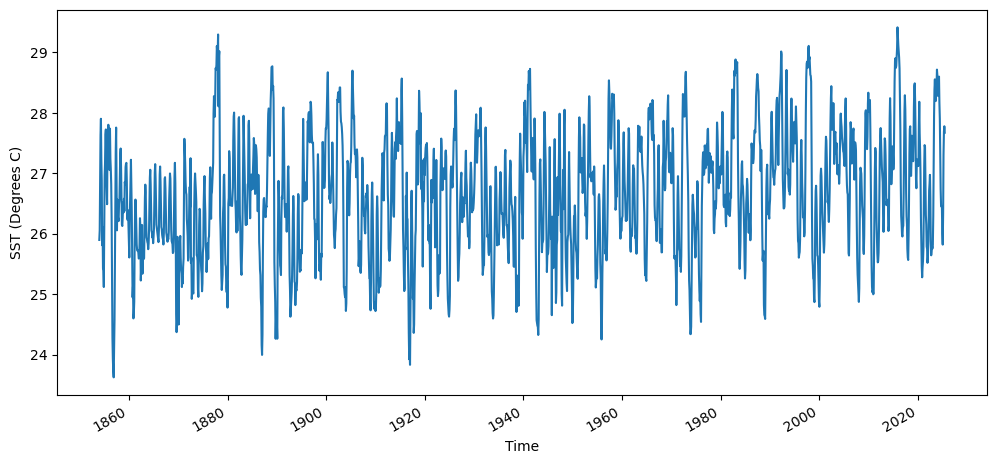

In [6]:
fig = plt.figure(figsize=(12,5))
sst_n34.plot()
plt.ylabel("SST (Degrees C)")

Compute the montly climatology from 1950 - 1979 for the area-averaged total SST for this region, and subtract the climatology from the area averaged total SST time series to obtain anomalies.

In [7]:
sst_n34_1950_1979 = sst_n34.isel(time = sst_n34.time.dt.year.isin(range(1950, 1980)))

Text(0, 0.5, 'SST (Degrees C)')

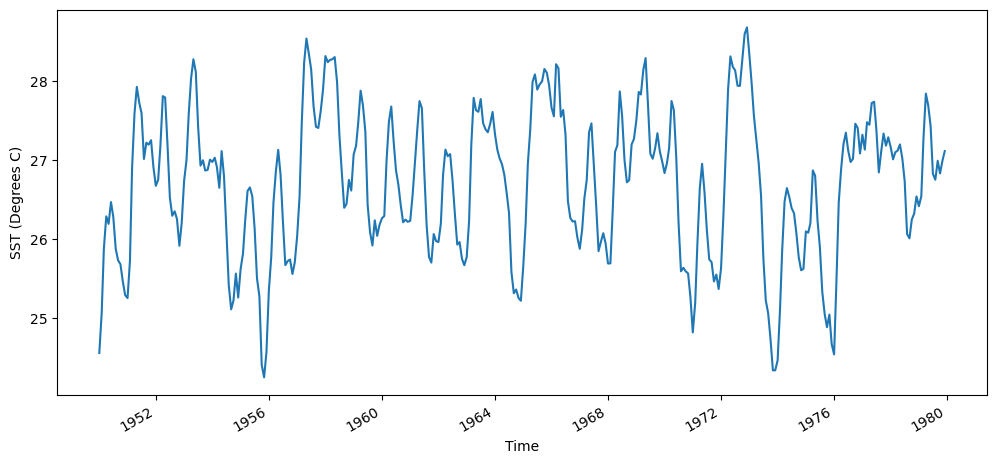

In [8]:
fig = plt.figure(figsize=(12,5))
sst_n34_1950_1979.plot()
plt.ylabel("SST (Degrees C)")

We'll find the mean temperature each month using the groupby function:

In [9]:
sst_n34_clim = sst_n34_1950_1979.groupby('time.month').mean()
print(sst_n34_clim.values)

[26.272535 26.49191  26.975252 27.355328 27.46776  27.296291 26.872158
 26.441786 26.319078 26.302315 26.313202 26.282764]


We can then subtract the monthly averaged climatology from the time series of SSTs

In [10]:
sst_n34_anom = sst_n34.groupby('time.month')-sst_n34_clim

Text(0, 0.5, 'SST Anom. (Degrees C)')

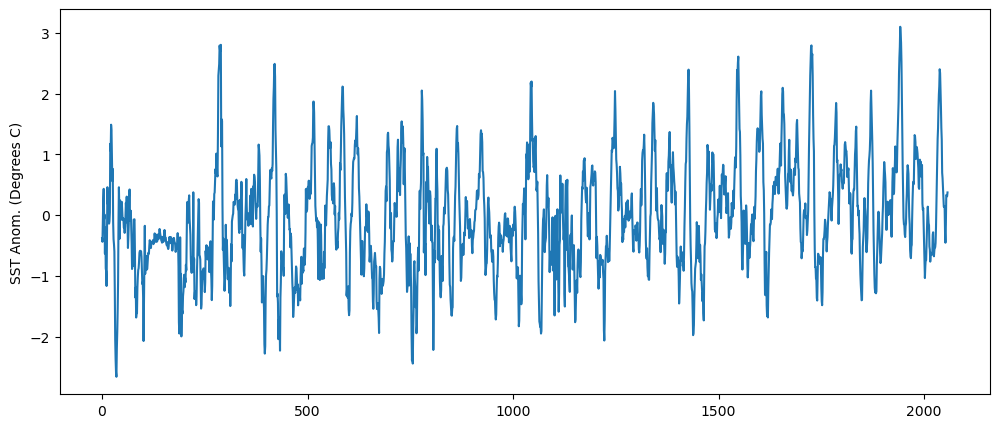

In [11]:
fig = plt.figure(figsize=(12,5))
plt.plot(sst_n34_anom)
plt.ylabel("SST Anom. (Degrees C)")

3. Smooth the anomalies with a 5-month running mean.
We'll smooth this out by applying a 5-month running-mean smoothing to the time series of anomalies.

In [12]:
sst_n34_smoothed = sst_n34_anom.rolling(time = 5,center=True).mean()

4. Standardize the smoothed Niño3.4 index by its standard deviation over the climatological period from 1950-1979.


In [13]:
n34_index = sst_n34_smoothed.groupby('time.month')/sst_n34_1950_1979.groupby('time.month').std()

Text(0, 0.5, 'Niño3.4 index')

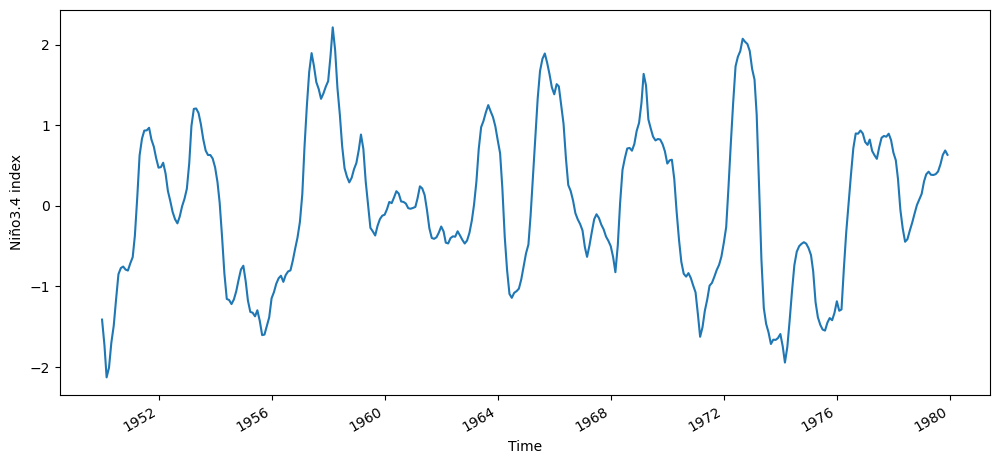

In [14]:
fig = plt.figure(figsize=(12,5))
n34_index.isel(time=n34_index.time.dt.year.isin(range(1950, 1980))).plot()
plt.ylabel("Niño3.4 index")

Text(0, 0.5, 'Niño3.4 index')

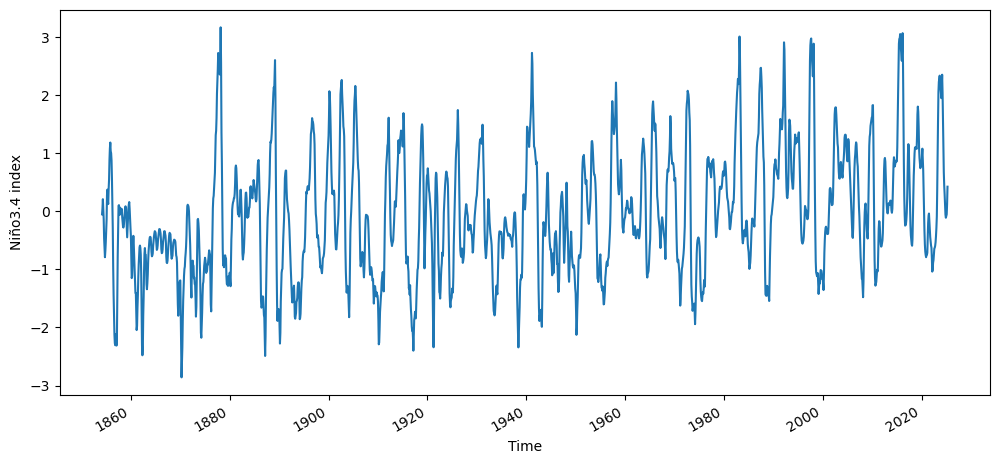

In [15]:
fig = plt.figure(figsize=(12,5))
n34_index.plot()
plt.ylabel("Niño3.4 index")

Now we will perform a PCA analysis of the tropical Pacific SST, and see if we can recreate the Niño3.4 index time series using the time series of PCs. 

We'll start by selecting a slightly larger region of the original data sets (-30S-30N, 120E-300E). This is so that we can better understand the spatial modes of variability that are learned by the PCA analysis.

In [19]:
sst_pca = sst['sst'].sel(lat=slice(30,-30),lon=slice(120,300),time=slice('1950','2013'))

In [20]:
sst_pca

<xarray.DataArray 'sst' (time: 768, lat: 31, lon: 91)>
[2166528 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 30.0 28.0 26.0 24.0 22.0 ... -24.0 -26.0 -28.0 -30.0
  * lon      (lon) float32 120.0 122.0 124.0 126.0 ... 294.0 296.0 298.0 300.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2013-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

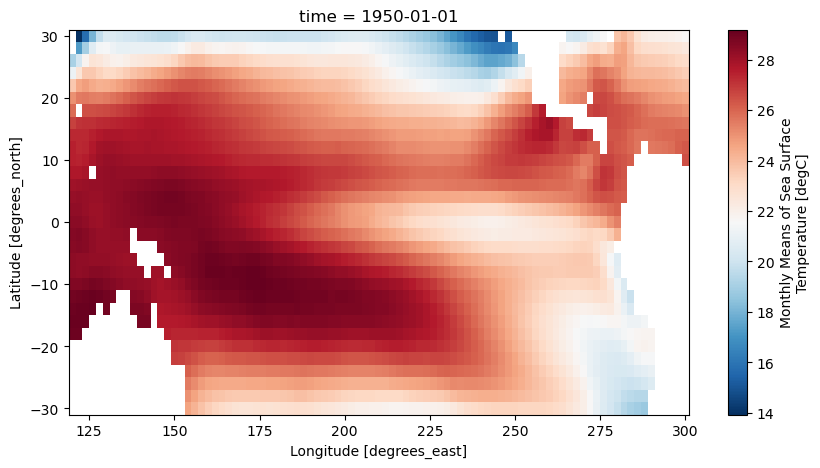

In [21]:
plt.figure(figsize=(10,5))
sst_pca[0].plot(cmap='RdBu_r')

To apply PCA to the SST data sets, we will first fill in missing values, since PCA will not work if we have missing values. Where the continents are located is NaN in this data set, so we will fill any of these values with 0.0

In [22]:
ssta_pca_masked = sst_pca.fillna(0)

Now we will use the `sci-kit learn` PCA function to calculate the principal components of the SST in this region. 

First, we will create a numpy array called `X` that contains the SST in the region that we have selected, where the sample number is each time step (1 month), and the spatial pattern is our feature matrix.

In [23]:
X = ssta_pca_masked.values
X.shape

(768, 31, 91)

In order to use the PCA function in `sci-kit learn`, we have to reshape the array so that it is $n_{samples}$ by $n_{features}$

In [24]:
nt = X.shape[0]
nlat = X.shape[1]
nlon = X.shape[2]

X = X.reshape(nt,nlat*nlon)
X.shape

(768, 2821)

Next, we will standardize the data by subtracting the mean and dividing by the standard deviation of the data set.

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scaler  = StandardScaler()

X_scaled = scaler.fit_transform(X)

Now we will apply PCA to the scaled and flattened monthly averaged-SST

In [29]:
pca = PCA()
PCs = pca.fit_transform(X_scaled)

We will also standardize the PCs, so we can compare against the Niño3.4 index.

In [30]:
scaler_PCs = StandardScaler()
PCs_std = scaler_PCs.fit_transform(PCs)

We can look at the fraction of variance explained by each of the EOF's

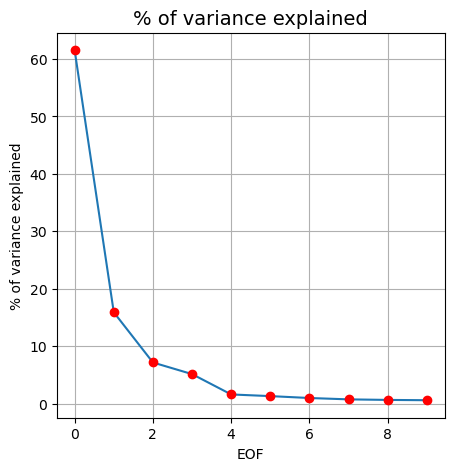

In [32]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(pca.explained_variance_ratio_[0:10]*100)
ax.plot(pca.explained_variance_ratio_[0:10]*100,'ro')
ax.set_xlabel("EOF")
ax.set_ylabel("% of variance explained")
ax.set_title("% of variance explained", fontsize=14)
ax.grid()

To access the spatial modes of variability that were learned by PCA from the monthly-averaged SST, we can use the .components_ method.

In [33]:
EOFs = pca.components_
EOFs.shape

(768, 2821)

We can directly visualize the spatial patterns of the EOFs. We have to reshape to the original region size though in order to do this.

In [34]:
EOF1 = EOFs[0,:].reshape(nlat,nlon)

Text(0.5, 1.0, 'EOF 1')

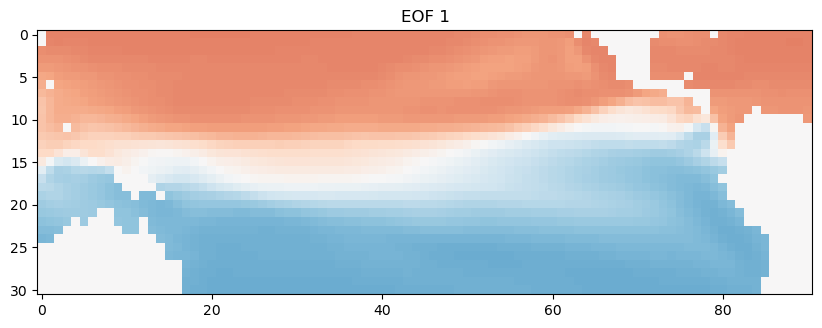

In [35]:
plt.figure(figsize=(10,5))
plt.imshow(EOF1, cmap='RdBu_r')
plt.clim(-0.05,0.05)
plt.title('EOF 1')

We can also look at how the time series of this spatial pattern changes over time. We'll just look at the first 120 months. This dominant spatial mode corresponds to the seasonal cycle, which we can clearly see emerge when we look at this first decade of the time series.

In [36]:
plt.plot(ssta_pca_masked.time[0:120],PCs_std[0:120,0])
plt.title("EOF1")
plt.xlabel("Time")
plt.ylabel("PC1")

Text(0, 0.5, 'PC1')

Now, we'll look at the second EOF, which explains the next most important mode of variability in the data set. 

In [37]:
EOF2 = EOFs[1,:].reshape(nlat,nlon)

Text(0.5, 1.0, 'EOF 2')

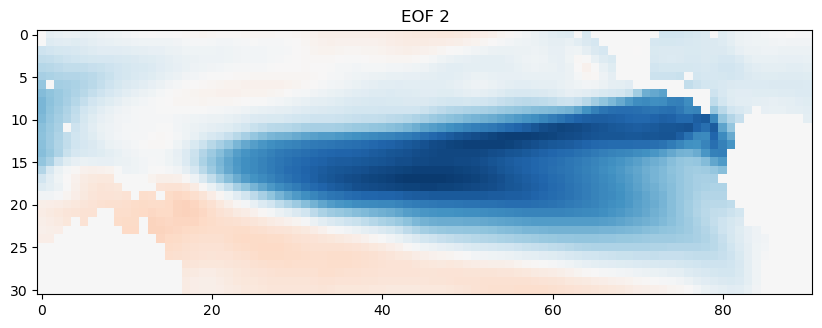

In [45]:
plt.figure(figsize=(10,6))
plt.imshow(EOF2, cmap='RdBu_r')
plt.clim(-0.05,0.05)
plt.title('EOF 2')

This second spatial mode of variability corresponds to the ENSO. We can compare this time series against the time series of Niño3.4 indices that we calculated earlier.

In [47]:
n34index = n34_index.sel(time=slice('1950','2013')).values

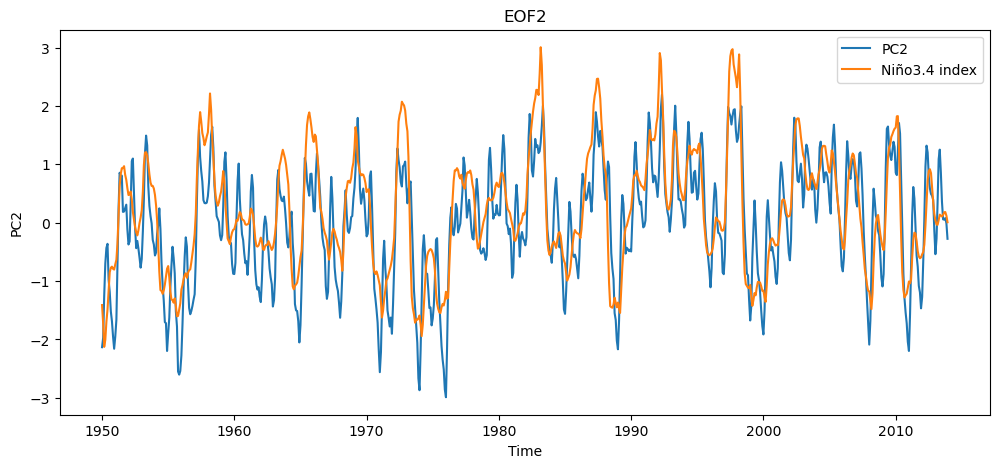

In [48]:
fig = plt.figure(figsize=(12,5))
plt.plot(ssta_pca_masked.time,-1*PCs_std[:,1],label="PC2")
plt.plot(ssta_pca_masked.time,n34index,label="Niño3.4 index")
plt.title("EOF2")
plt.xlabel("Time")
plt.ylabel("PC2")
plt.legend()

The Niño3.4 index is smoother (because we applied a 5 month moving average) but overall the PCA analysis has captured the same time scale and mode of variability as the ENSO metric.